# Corpus shift KL minimisation


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [57]:
# Generate example data
m = 10000
# Target distribution
mu0 = np.array([120]); sig0 = np.array([10])
mu1 = np.array([130]); sig1 = np.array([15])
X0 = np.random.normal(loc=mu0, scale=sig0, size=m // 2)
X1 = np.random.normal(loc=mu1, scale=sig1, size=m // 2)
y0 = np.zeros(m // 2)
y1 = np.ones(m // 2)
X = np.concatenate([X0,X1])
y = np.concatenate([y0,y1])

target = pd.DataFrame({'feature' : X})
target['Outcome'] = y

# Corpus distribution
mu = np.array([125]); sig = np.array([20])
corpus = np.random.normal(loc=mu, scale=sig, size=m)
corpus = pd.DataFrame({'feature': corpus})

Plot histograms for corpus and target distribution

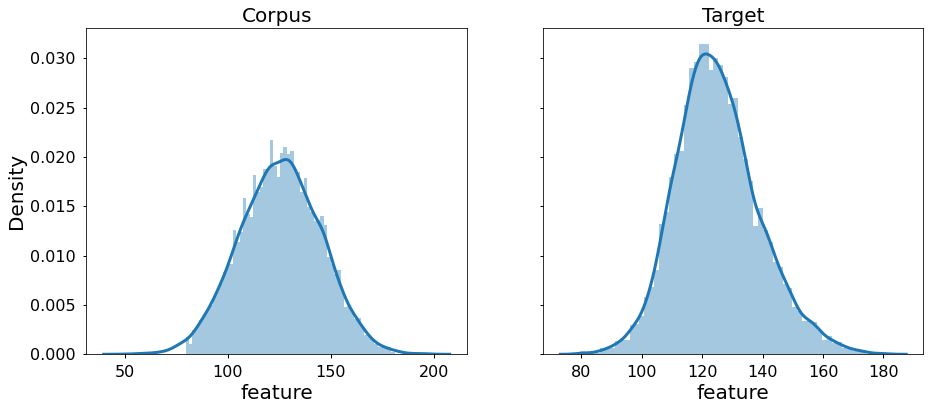

In [58]:
bins_target = np.histogram_bin_edges(target['feature'],bins='auto')
bins = np.histogram_bin_edges(corpus['feature'],bins='auto')


fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=True)

sns.distplot(corpus['feature'], bins=bins_target,ax=axs[0], kde_kws=dict(linewidth=3))
sns.distplot(target['feature'], bins=bins_target,ax=axs[1], kde_kws=dict(linewidth=3))
axs[0].set_title('Corpus', fontsize=20)
axs[1].set_title('Target', fontsize=20)
plt.savefig('simple_cont_corp_targ.jpg')
plt.show()

Text(0.5, 1.0, 'Target')

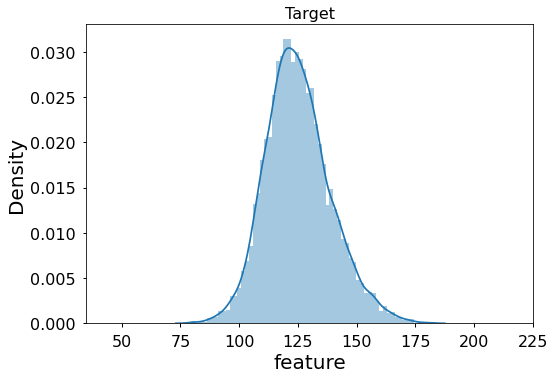

In [59]:
bins_target = np.histogram_bin_edges(target['feature'],bins='auto')
sns.distplot(target['feature'],bins=bins_target)
plt.xlim([35,225])
plt.title("Target")

In [60]:
histLoss0 = emm.losses.CorpusKLLoss(mean=mu0, std=sig0)
histLoss1 = emm.losses.CorpusKLLoss(mean=mu1, std=sig1)
lam  = 1
marg = {0 : {'feature' : {'fun' : [histLoss0.fun], 'loss' : [histLoss0]},
             'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                              'lam' : lam}},
        1 : {'feature' : {'fun' : [histLoss1.fun], 'loss' : [histLoss1]},
             'regularizer' : {'reg' : emm.regularizers.EntropyRegularizer(),
                              'lam' : lam}}}

rw_corpus = emm.reweighting.generate_synth(corpus,marg)

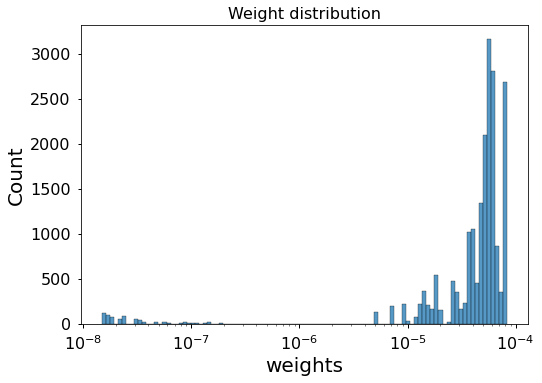

Maximum entropy weight value = 5e-05


In [61]:
# Plot distribution of weights
sns.histplot(rw_corpus['weights'], bins=100, log_scale=True)
plt.title("Weight distribution")
plt.show()
print('Maximum entropy weight value = ' + str(1 / (rw_corpus.shape[0])))

Plot of the reweighted corpus for each outcome

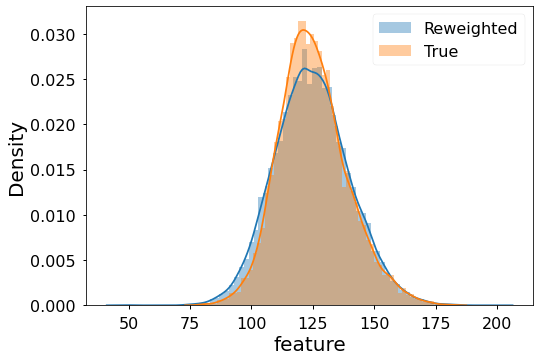

In [62]:
emm.utils.weighted_hist(rw_corpus['feature'], rw_corpus['weights'], label='Reweighted')
sns.distplot(target['feature'], bins=bins_target, label='True')
plt.legend()
plt.show()

### Performance metrics

In [63]:
width = bins_target[1] - bins_target[0]
emm.metrics.compute_js_distance(target, rw_corpus)

0.075709360197432

In [64]:
from sklearn.tree import DecisionTreeClassifier
param_grid =  {'classifier' : [DecisionTreeClassifier()],
     'classifier__max_depth' : [2,4,6,7,9]}
emm.metrics.classifier_metric(target, rw_corpus, param_grid, verbose=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier(max_depth=2)
 the best mean cross-validation accuracy 67.25 +/- 0.59029% on training dataset 



{'accuracy_score': {'RR': 0.6595,
  'RS': 0.6190174167343111,
  'SS': 0.6173485425062296,
  'SR': 0.659}}

In [65]:
from sklearn.linear_model import LogisticRegression
param_grid =  {'classifier' : [LogisticRegression()],
     "classifier__C":np.logspace(-3,3,7), "classifier__penalty":["l1","l2"]}
emm.metrics.classifier_metric(target, rw_corpus, param_grid, verbose=True)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Target data: the best parameters are given by 
 LogisticRegression(C=0.001)
 the best mean cross-validation accuracy 65.2625 +/- 1.329% on training dataset 



{'accuracy_score': {'RR': 0.662,
  'RS': 0.6070949235978718,
  'SS': 0.6111369378892252,
  'SR': 0.66}}